In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from utils.augmentations import frequency_augmentation, time_augmentation
from utils.dataset import TFC_Dataset
from utils.models import TFC_encoder, ContrastiveLoss
from torch.optim import Adam

In [2]:
path = 'datasets/ECG/'
train = torch.load(path + 'train.pt')
val = torch.load(path + 'val.pt')
test = torch.load(path + 'test.pt')

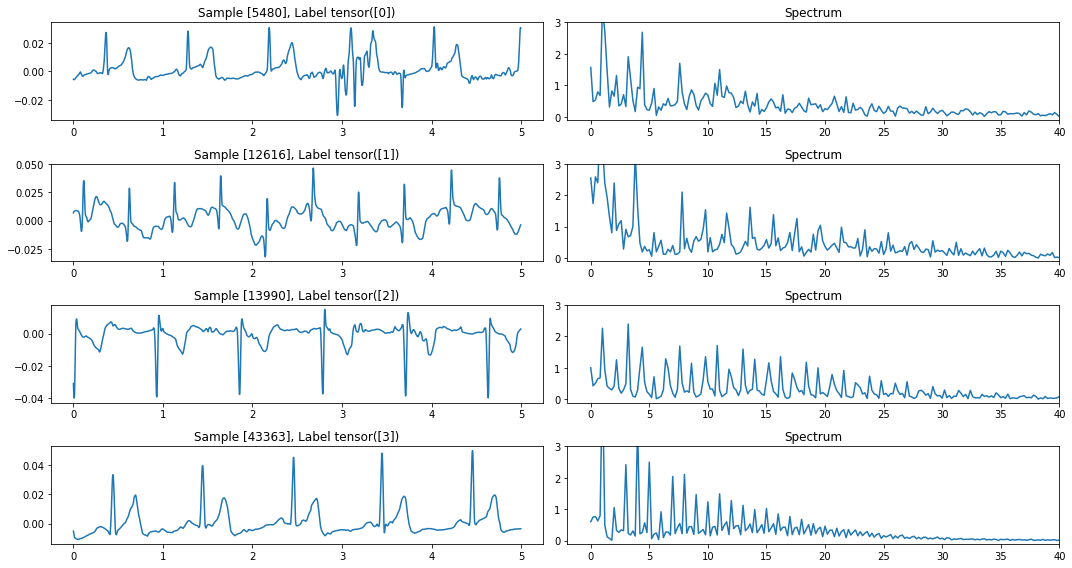

In [3]:
idx = []

for lab in range(4):
    id = np.random.choice(np.where(train['labels'] == lab)[0], 1)
    idx.append(id)

fig1, ax1 = plt.subplots(4, 2, figsize = (15,8))

#fig2, ax2 = plt.subplots(4, 2, figsize = (15,8))
freqs = np.fft.rfftfreq(1500, d = 1/300)
time = np.arange(1500)/300

for j, id in enumerate(idx):
    samp = train['samples'][id,0,:].squeeze()
    label = train['labels'][id]
    ax1[j, 0].plot(time, samp)
    ax1[j, 0].set_title('Sample {}, Label {}'.format(id, label))
    fft = np.fft.rfft(samp)
    ax1[j, 1].plot(freqs, abs(fft))
    ax1[j, 1].set_title('Spectrum'.format(id, label))
    ax1[j,1].set_xlim([-2,40])
    ax1[j,1].set_ylim([-0.1,3])
        
plt.tight_layout()
plt.show()


In [5]:
x = train['samples']

In [6]:
n_samples = 3
# Examine augmentations
idx = np.random.choice(np.arange(len(x)), n_samples)

freq_cont = torch.fft.fft(x[idx], axis = -1)
freq_aug, time_freq_aug = frequency_augmentation(freq_cont)
time_aug, freq_time_aug = time_augmentation(x[idx], keep_all = True)

/Users/theb/Documents/PhD/code/self-supervision/utils/augmentations.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_sig = np.concatenate(np.random.permutation(sig_split), axis = 0)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


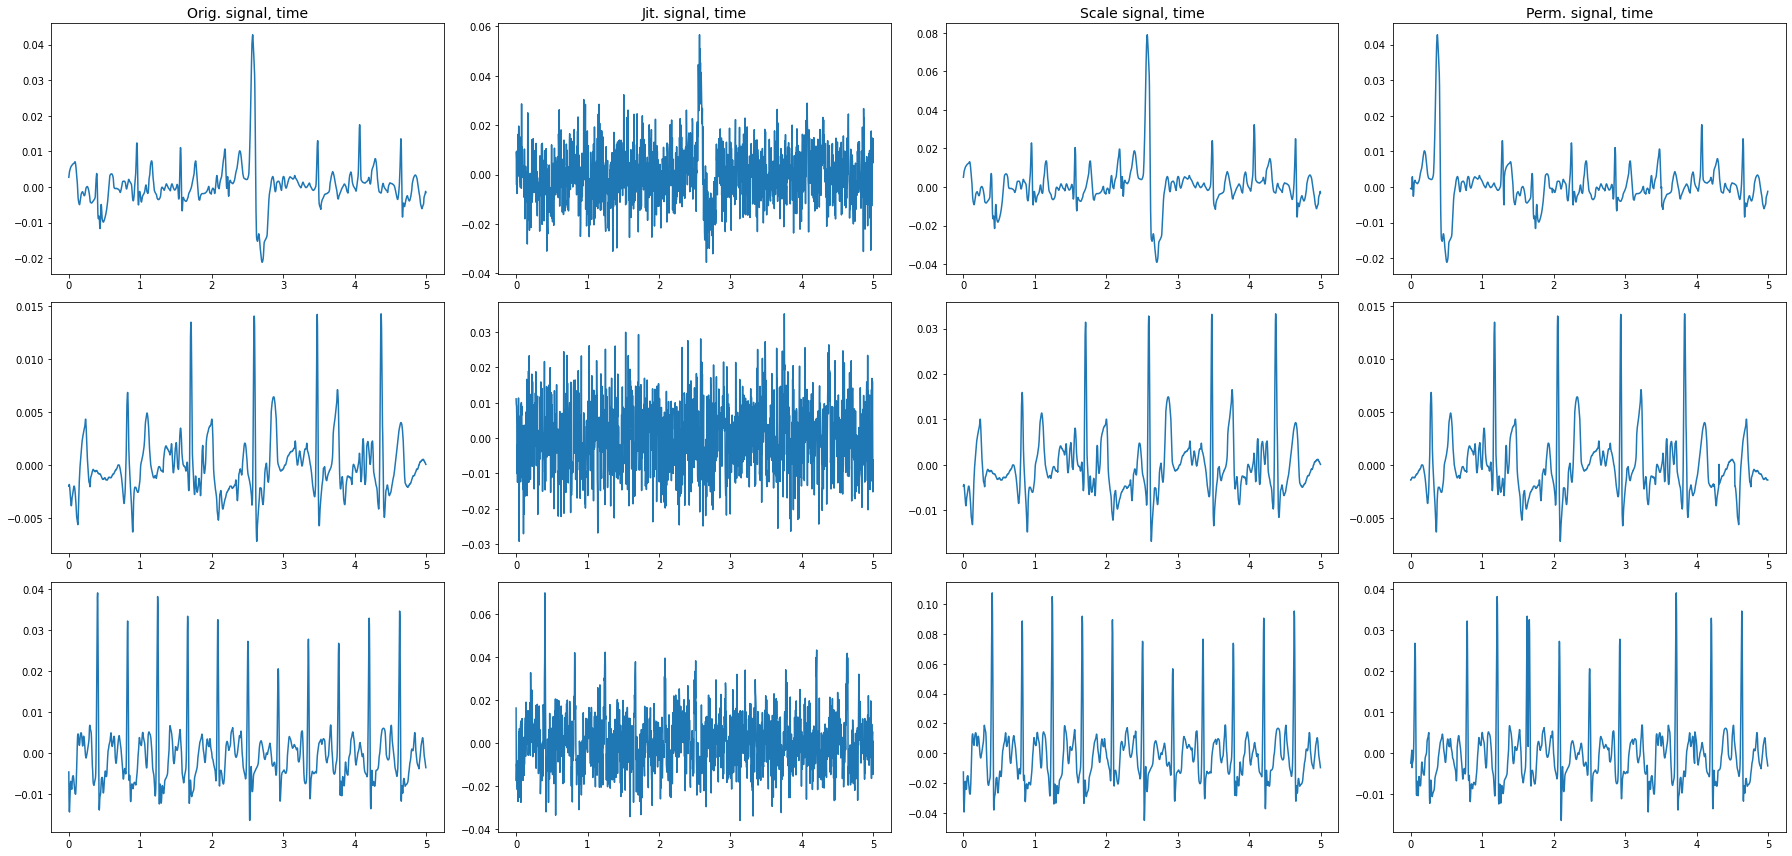

In [8]:
# Examine augmentations
fig, axes = plt.subplots(nrows= n_samples, ncols = 4, figsize=(25, 12))
time = np.arange(1500)/300
freq = np.fft.fftfreq(1500, 1/300)
augmentations = ['Orig. signal, time', 'Orig. signal, freq', 'Jit. signal, time', 'Jit. signal, freq', 'Scale signal, time', 'Scale signal, freq', 'Perm. signal, time', 'Perm. signal, freq']

for i, row in enumerate(axes):
    for j in range(0, 2*len(row), 2):
        for k in range(1):
            ax = row[int(j/2)]
            if i == 0:
                ax.set_title(augmentations[j+k], fontsize = 14)
            if k == 0:
                ax.plot(time, time_aug[i,int(j/2),0,:])
            else:
                ax.plot(freq, freq_time_aug[i,int(j/2),0,:])
                ax.set_xlim([0, 30])

plt.tight_layout()
plt.show()

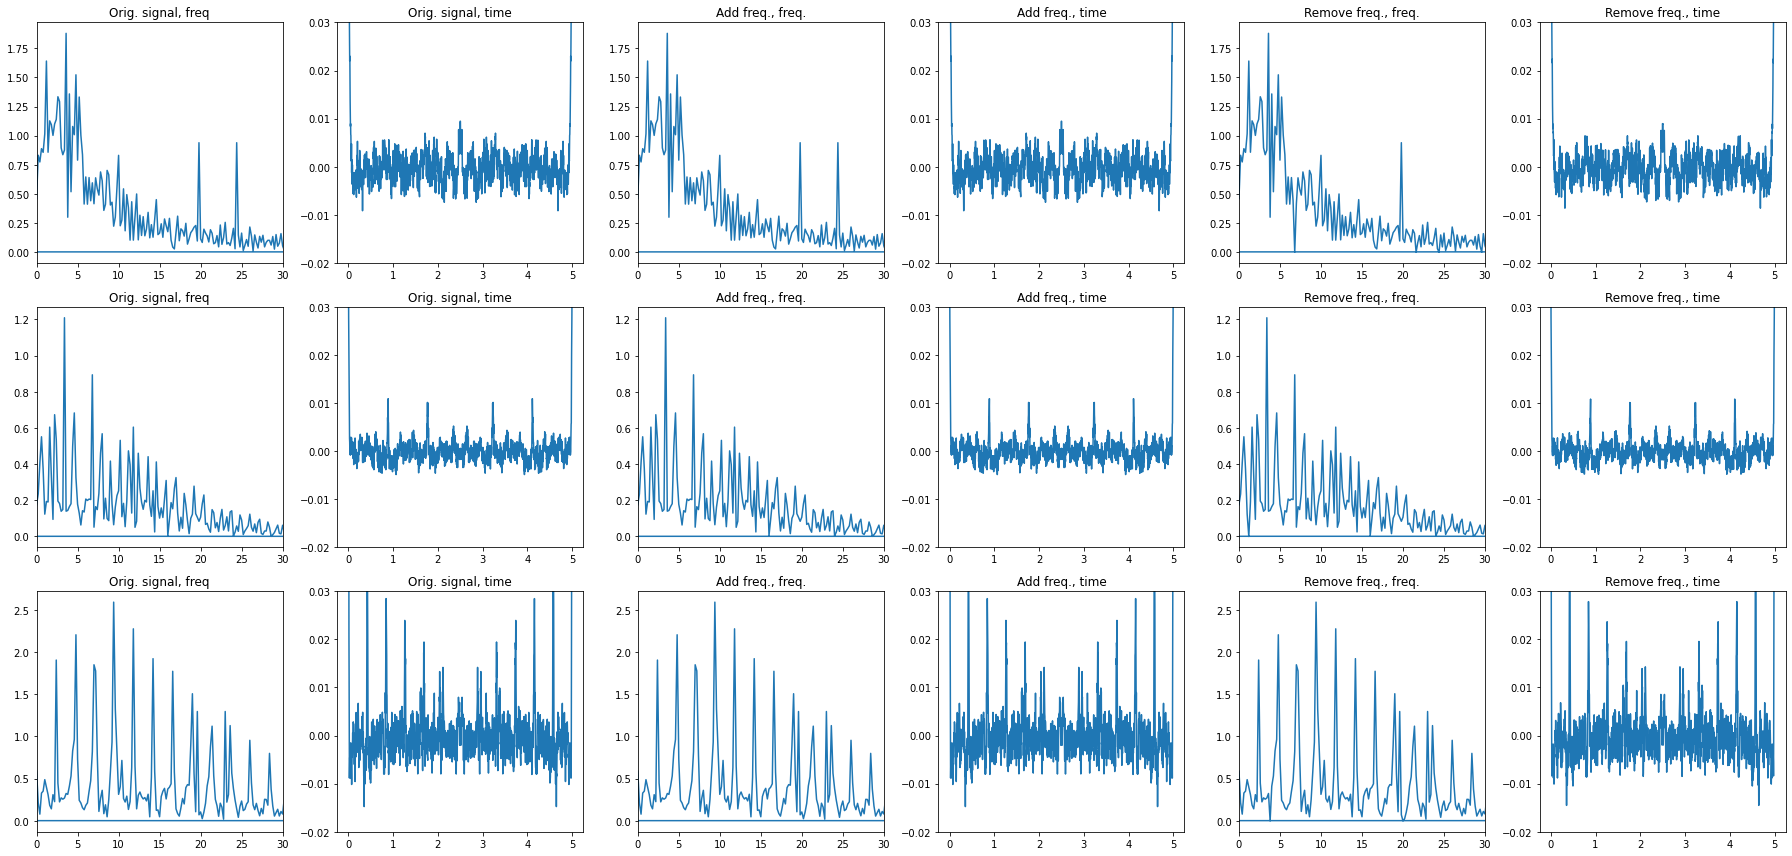

In [9]:
# Examine augmentations
fig, axes = plt.subplots(nrows= n_samples, ncols = 6, figsize=(25, 12))
time = np.arange(1500)/300
freq = np.fft.fftfreq(1500, 1/300)
augmentations = ['Orig. signal, freq', 'Orig. signal, time', 'Add freq., freq.', 'Add freq., time', 'Remove freq., freq.', 'Remove freq., time']

for i, row in enumerate(axes):
    for j in range(0, len(row), 2):
        for k in range(2):
            ax = row[j+k]
            ax.set_title(augmentations[j+k])
            if k == 0:
                ax.plot(freq, freq_aug[i,int(j/2),0,:])
                ax.set_xlim([0, 30])
            else:
                ax.plot(time, time_freq_aug[i,int(j/2),0,:])
                ax.set_ylim([-0.02, 0.03])

plt.tight_layout()
plt.show()

In [8]:
class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        """Criterion has an internal one-hot function. Here, make all positives as 1 while all negatives as 0. """
        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [20]:
class ContrastiveLoss(nn.Module):
    def __init__(self, tau, batchsize, device):
        super().__init__()
        self.tau = tau
        self.batchsize = batchsize
        self.device = device
        self.cosine_similarity = nn.CosineSimilarity(dim = -1)
        self.criterion = nn.CrossEntropyLoss(reduction = 'sum')

        # compute negative mask
        upper = np.eye(2*batchsize, 2*batchsize, k = batchsize)
        lower = np.eye(2*batchsize, 2*batchsize, k = -batchsize)
        diag = np.eye(2*batchsize)

        self.negative_mask = torch.from_numpy(1-(upper+lower+diag)).bool().to(device)

    def forward(self, z_orig, z_augment):
        collect_z = torch.cat([z_augment, z_orig], dim = 0)
        # calculate cosine similarity between all augmented and
        # non-augmented latent representations
        similarities = self.cosine_similarity(collect_z.unsqueeze(1), collect_z.unsqueeze(0))

        # get the positive samples (upper and lower diagonal)
        upper_pos = torch.diag(similarities, self.batchsize)
        lower_pos = torch.diag(similarities, -self.batchsize)
        positive = torch.cat((upper_pos, lower_pos), dim = 0).unsqueeze(1)

        # get the negative samples by masking out the diagonal and the upper 
        # and lower diagonal
        negative = similarities[self.negative_mask].view(2*self.batchsize, -1)

        # concatenate the logits
        logits = torch.cat((positive, negative), dim = 1)
        logits /= self.tau
        
        # calculate loss using cross entropy by setting the "labels" to zero:
        # we have the positive samples on the 0th index in the logits and all 
        # other samples on the remaining indices - i.e. force the 0th "class"
        # to be large and all other to be smal
        labels = torch.zeros(2*self.batchsize).to(self.device).long()
         
        loss = self.criterion(logits, labels)
        return loss / (2*self.batchsize)
        

In [21]:
TFC_dset = TFC_Dataset(train['samples'], train['labels'])
train_loader = DataLoader(TFC_dset, batch_size = 64, shuffle = True, drop_last=True)

In [22]:
val_dset = TensorDataset(val['samples'], val['labels'])

In [23]:
out = TFC_dset.__getitem__(0)

In [24]:
temp = next(iter(train_loader))

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = ContrastiveLoss(tau = 0.2, batchsize=64, device = device)
nexent = NTXentLoss(device, 64, 0.2, True)

model = TFC_encoder(in_channels = 1, input_size = 1500, num_classes = 4, classify = True).to(device)
optimizer = Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)

In [26]:
h_t, z_t, h_f, z_f, out = model(temp[0].float(), temp[1].float())
h_t_aug, z_t_aug, h_f_aug, z_f_aug, _ = model(temp[2].float(), temp[3].float())

time_loss = loss_fn(h_t, h_t_aug)
freq_loss = loss_fn(h_f, h_f_aug)

In [27]:
time_loss

tensor(4.7130, grad_fn=<DivBackward0>)

In [28]:
time_loss_2 = nexent(h_t, h_t_aug)
time_loss_2

tensor(4.7130, grad_fn=<DivBackward0>)

In [12]:
epochs = 2
time_loss_total = []
freq_loss_total = []
time_freq_loss_total = []
loss_total = []
lambda_ = 0.5 
delta_ = 1

for epoch in range(epochs):
    epoch_time, epoch_freq, epoch_time_freq, epoch_loss = [0, 0, 0, 0]
    for i, (x_t, x_f, x_t_aug, x_f_aug, y) in enumerate(train_loader):
        x_t, x_f, x_t_aug, x_f_aug, y = x_t.float().to(device), x_f.float().to(device), x_t_aug.float().to(device), x_f_aug.float().to(device), y.float().to_device()

        h_t, z_t, h_f, z_f, out = model(x_t, x_f)
        h_t_aug, z_t_aug, h_f_aug, z_f_aug, _ = model(x_t_aug, x_f_aug)

        time_loss = loss_fn(h_t, h_t_aug)
        freq_loss = loss_fn(h_f, h_f_aug)

        time_freq_pos = loss_fn(z_t, z_f)
        time_freq_neg  = loss_fn(z_t, z_f_aug), loss_fn(z_t_aug, z_f), loss_fn(z_t_aug, z_f_aug)
        loss_TFC = 3*time_freq_pos - time_freq_neg[0] - time_freq_neg[1] - time_freq_neg[2] + 3*delta_

        loss = lambda_*(time_loss + freq_loss) + (1-lambda_)*loss_TFC

        epoch_time += time_loss.detach().cpu()
        epoch_freq += freq_loss.detach().cpu()
        epoch_time_freq += loss_TFC.detach().cpu()
        epoch_loss += loss.detach().cpu()

        loss.backward()
        optimizer.step()
        
    time_loss_total.append(epoch_time)
    freq_loss_total.append(epoch_freq)
    time_freq_loss_total.append(epoch_time_freq)
    loss_total.append(epoch_loss)




1 of 2
0 of 682
1 of 682
2 of 682
3 of 682
4 of 682


KeyboardInterrupt: 